In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os 
import re
sns.set_theme('paper')

In [337]:
spectra_allstokes = pd.DataFrame()
spectra_normstokes = pd.DataFrame()
spectra_Istokes = pd.DataFrame()
sources = []
for source_dir in os.listdir('../spectra_files'):
    source_path = os.path.join('../spectra_files', source_dir)
    if os.path.isdir(source_path):
        obs_trimmed = f'{source_path.split("/")[-1]}'
        sources.append(obs_trimmed)
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')
                    spectrum = pd.read_csv(f'{obsid_path}/spectra_0.2.csv')
                    stokes = np.concatenate([spectrum['I'], spectrum['Q'], spectrum['U']])
                    normstokes = np.concatenate([spectrum['Q']/spectrum['I'], spectrum['U']/spectrum['I']])
                    spectra_allstokes[f'{obsid_trimmed}'] = stokes
                    spectra_normstokes[f'{obsid_trimmed}'] = normstokes
                    spectra_Istokes[f'{obsid_trimmed}'] = spectrum['I']



Processing swift_j1727/03006001
Processing swift_j1727/02251301
Processing swift_j1727/02250901
Processing swift_j1727/02251001
Processing swift_j1727/03005801
Processing swift_j1727/02251101
Processing swift_j1727/03005701
Processing swift_j1727/02251201
Processing cen_x-3/01250201
Processing cen_x-3/01006501
Processing gro_j1008-57/02003501
Processing gro_j1008-57/02003601
Processing gx_5-1/02002799
Processing gx_9+1/03003801
Processing gx_3+1/03004101
Processing v395_car/03001201
Processing gx_9+9/01002401
Processing cir_x-1/02002699
Processing lmc_x-1/02001901
Processing 4u_1735-44/03004001
Processing sco_x-1/02002401
Processing 4u_1820-303/02002399
Processing cyg_x-3/02001899
Processing cyg_x-3/02250301
Processing cyg_x-3/03250301
Processing cyg_x-3/02009101
Processing smc_x-1/02007001
Processing smc_x-1/02007101
Processing smc_x-1/02007201
Processing gx_340+0/03009901
Processing gx_340+0/03003301
Processing cyg_x-2/01001601
Processing cyg_x-2/01006601
Processing exo_2030+375/0225

In [338]:
# Assuming you have a dataframe `df` with your data
# Standardize the data before applying PCA
# spectra = spectra_Istokes
spectra = spectra_allstokes
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra.T)
# scaled_data = spectra
# Apply PCA
k = 30  # Number of components to keep
pca = PCA(n_components=k)  
# pca = PCA()  
principal_components = pca.fit_transform(scaled_data)

# Create a new dataframe with the principal components
# k = len(principal_components[0])
# columns = [f'PC{i+1}' for i in range(k)]
# pca_df = pd.DataFrame(data=principal_components, columns=columns)
# print(pca_df)

In [339]:
spectra = spectra_Istokes
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra.T)
k = 30  # Number of components to keep
pca = PCA(n_components=k)  
principal_components = pca.fit(scaled_data)
pcs = principal_components.components_
print(np.shape(pcs))

(30, 30)


In [340]:
# # Create a new dataframe with the principal components
# columns = [f'PC{i+1}' for i in range(k)]
# pca_df = pd.DataFrame(data=principal_components, columns=columns)
# print(pca_df)

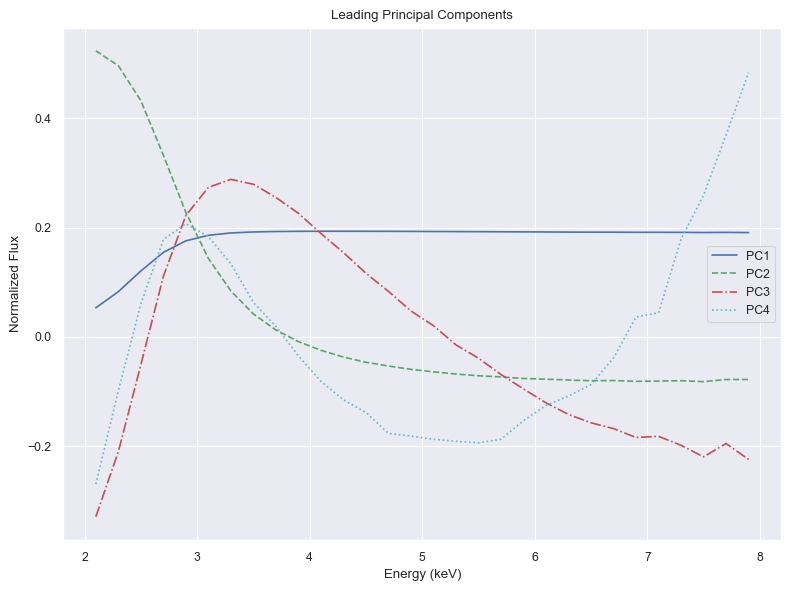

In [341]:
# Plot the leading two principal components

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyles = ['-', '--', '-.', ':']
for i, (pc, linestyle, color) in enumerate(zip(pcs[:4], linestyles, colors)):
    ax.plot(spectrum['energy'], pc, label=f'PC{i+1}', linestyle=linestyle, color=color)
# ax.plot(spectrum['energy'], pcs[1]-(pcs[3]-pcs[2]), label='PC2-PC4', linestyle='solid', color='k')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.set_title('Leading Principal Components')
fig.tight_layout()





# j = len(pca_df['PC1'])//30
# stokes = ['Q', 'U']
# if j == 3:
#     stokes = ['I', 'Q', 'U']
# fig, ax = plt.subplots(j, 1, sharex=True, figsize=(8, 6))
# if j == 1:
#     ax = [ax]
# for i in range(j):
#     ax[i].scatter(spectrum['energy'], pca_df['PC1'].iloc[30*i:30*(i+1)], label='PC1')
#     ax[i].scatter(spectrum['energy'], pca_df['PC2'].iloc[30*i:30*(i+1)], label='PC2')
#     ax[i].set_ylabel(f'{stokes[i]} PC')
# ax[j-1].set_xlabel('Energy (keV)')
# ax[0].legend()
# plt.tight_layout()
# plt.subplots_adjust(hspace=0)

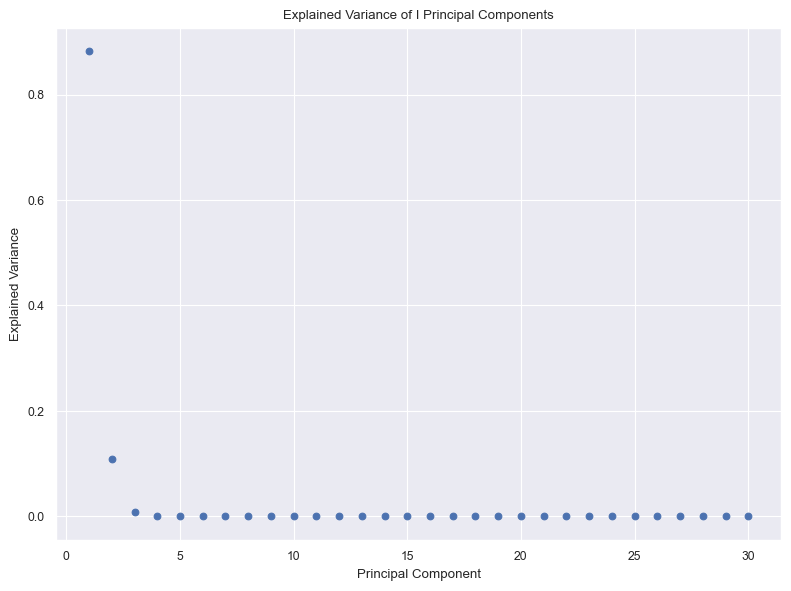

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_yscale('linear')
# ax.set_ylim(1e-4, 1)
ax.set_title('Explained Variance of I Principal Components')
fig.tight_layout()

In [343]:
def project_onto_pcs(test_data_point, pcs, k):
    """
    Projects a test data point onto the first k principal components.

    Parameters:
    test_data_point (array-like): The test data point to be projected.
    pcs (array-like): The principal components, shape (n, m).
    k (int): The number of principal components to project onto.

    Returns:
    array-like: The projection of the test data point onto the first k principal components.
    """
    # Ensure k does not exceed the number of principal components
    k = min(k, pcs.shape[0])
    
    # Select the first k principal components
    selected_pcs = pcs[:k, :]
    
    # Project the test data point onto the selected principal components
    projection = np.dot(selected_pcs, test_data_point)
    
    return projection

test_data_point = spectra.iloc[:, -3]
# test_data_point = spectra.iloc[:, 10]
test_data_point /= np.linalg.norm(test_data_point)
for k in range(1, 31):
    # k = 1  # Number of principal components to project onto

    projection = project_onto_pcs(test_data_point, pcs, k)
    projection_vectors = [projection[i] * pcs[i] for i in range(k)]
    reconstructed_data_point = np.sum(projection_vectors, axis=0)
    # print(reconstructed_data_point)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(spectrum['energy'], test_data_point, label='Original')
    ax.plot(spectrum['energy'], reconstructed_data_point, label='Projection')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Normalized Flux')
    ax.set_title(f'Projection onto {k} Principal Components of I Spectra')
    ax.legend()
    plt.savefig(f'IReconstructionImages/projection_{k}.png', bbox_inches='tight')
    plt.close()

Fitted parameters: a = 4.83554615511461, b = 2.5264022105694552, c = -0.13051206937763746


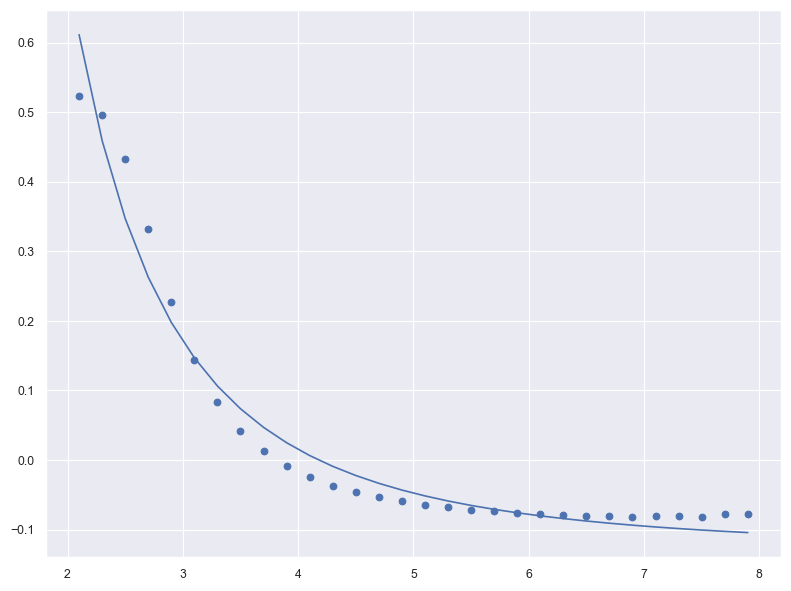

In [344]:
from scipy.optimize import curve_fit

def power_law(x, a, b, c):
    return a * np.power(x, -b) + c

def fit_power_law(x_data, y_data):
    """
    Fits data to a power-law function y = a * x^-b.

    Parameters:
    x_data (array-like): The independent variable data.
    y_data (array-like): The dependent variable data.

    Returns:
    tuple: The optimal values for the parameters a and b.
    """
    params, _ = curve_fit(power_law, x_data, y_data)
    return params

# Example usage

a, b, c = fit_power_law(spectrum['energy'], pcs[1])
print(f"Fitted parameters: a = {a}, b = {b}, c = {c}")
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(spectrum['energy'], pcs[1], label='PC1')
ax.plot(spectrum['energy'], power_law(spectrum['energy'], a, b, c), label='Fit')
fig.tight_layout()

Fitted parameters: a = -0.1384980601031286, b = -0.9109791118538191


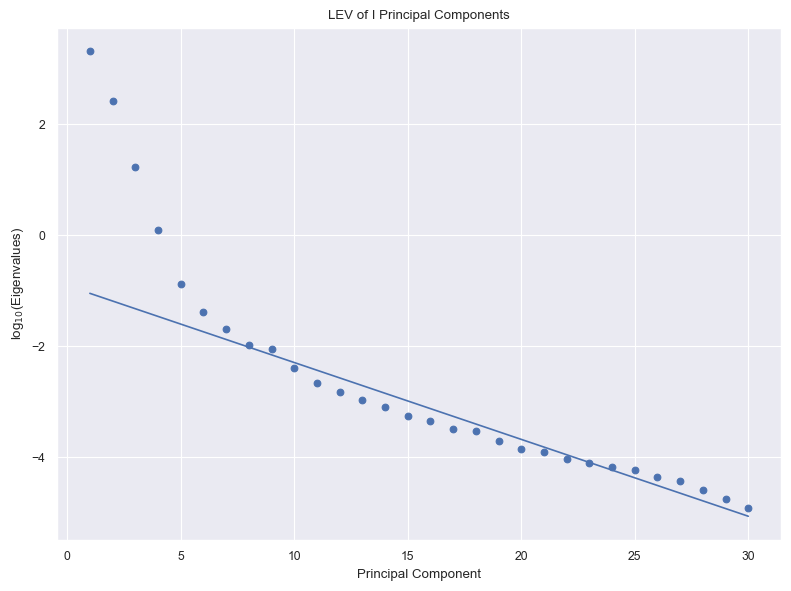

In [345]:
def line(x, a, b):
    return a * x + b

def fit_line(x_data, y_data):
    """
    Parameters:
    x_data (array-like): The independent variable data.
    y_data (array-like): The dependent variable data.

    Returns:
    tuple: The optimal values for the parameters a and b.
    """
    params, _ = curve_fit(line, x_data, y_data)
    return params

# Example usage
l = 4
eigenvalues = pca.singular_values_**2
x = np.array(range(1, len(eigenvalues)+1))
a, b = fit_line(x[l:], np.log10(eigenvalues[l:]))
print(f"Fitted parameters: a = {a}, b = {b}")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(x, np.log10(eigenvalues), label='Explained Variance')
ax.plot(x, line(x, a, b), label='Fit')
ax.set_xlabel('Principal Component')
ax.set_ylabel(r'log$_{10}$(Eigenvalues)')
ax.set_yscale('linear')
ax.set_title('LEV of I Principal Components')
# ax.set_ylim(1e-4, 1)
fig.tight_layout()

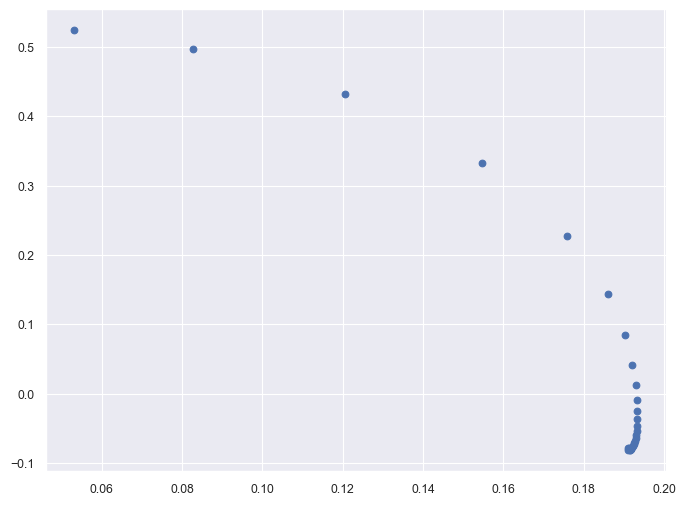

In [346]:
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.scatter(pcs[0], pcs[1])

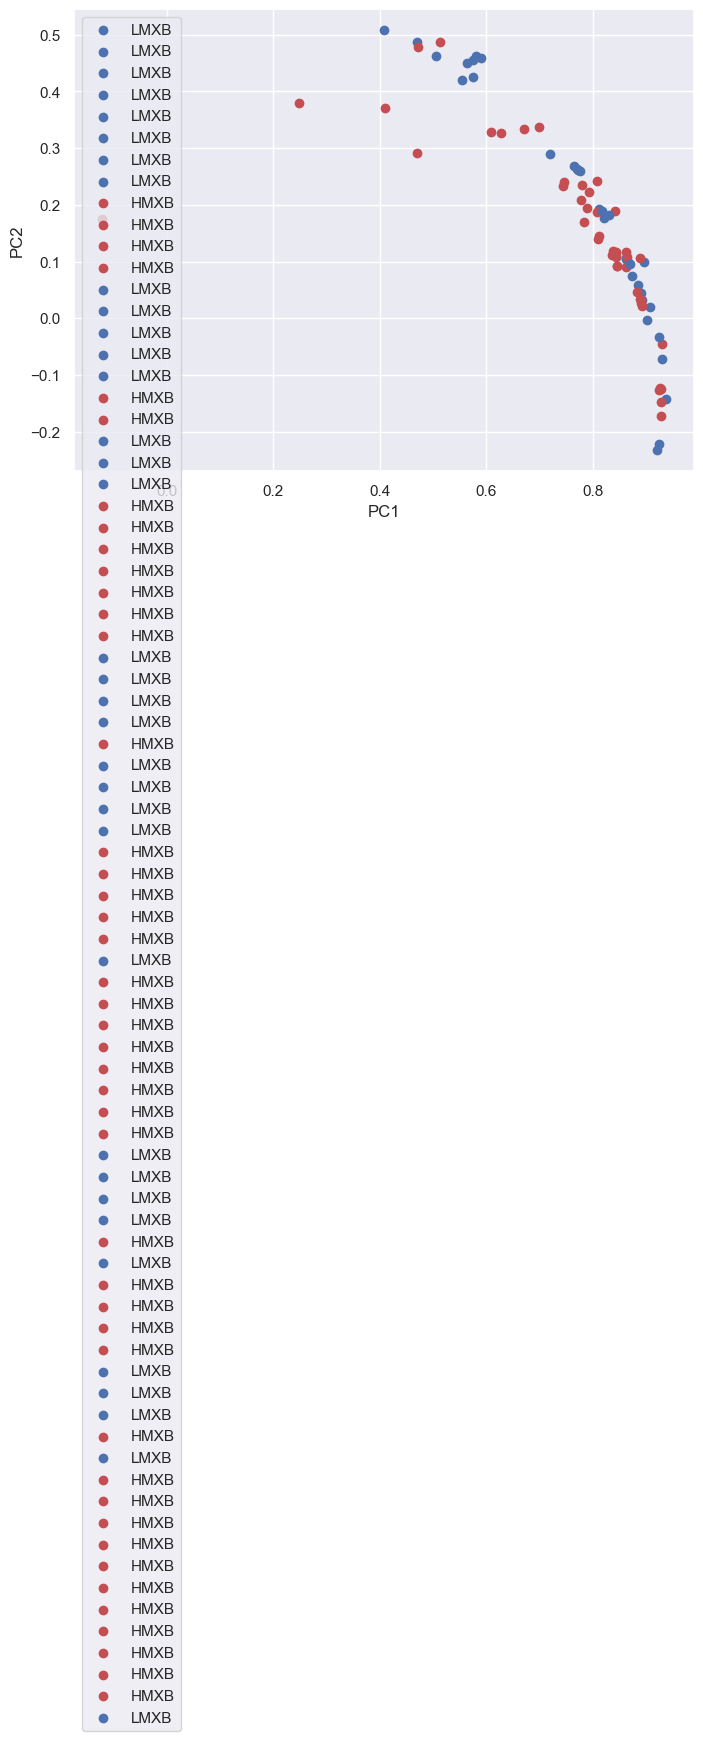

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
xray_binary_classification = {
    'swift_j1727': 'LMXB',
    'cen_x-3': 'HMXB',
    'gro_j1008-57': 'HMXB',
    'gx_5-1': 'LMXB',
    'gx_9+1': 'LMXB',
    'gx_3+1': 'LMXB',
    'v395_car': 'LMXB',
    'gx_9+9': 'LMXB',
    'cir_x-1': 'HMXB',
    'lmc_x-1': 'HMXB',
    '4u_1735-44': 'LMXB',
    'sco_x-1': 'LMXB',
    '4u_1820-303': 'LMXB',
    'cyg_x-3': 'HMXB',
    'smc_x-1': 'HMXB',
    'gx_340+0': 'LMXB',
    'cyg_x-2': 'LMXB',
    'exo_2030+375': 'HMXB',
    'gx_13+1': 'LMXB',
    '4u_1728-34': 'LMXB',
    'vela_x-1': 'HMXB',
    'ls_v+44_17': 'HMXB',
    'swift_j0234': 'HMXB',
    'gx_349+2': 'LMXB',
    'gx_301-2': 'HMXB',
    'mcg-5-23-16': 'HMXB',
    '4u_1630-47': 'HMXB',
    '4u_1538-52': 'HMXB',
    'swift_j151857': 'HMXB',
    '4u_1957+115': 'LMXB',
    'gx_339-4': 'LMXB',
    'lmc_x-3': 'LMXB',
    'x_persei': 'HMXB',
    '4u_1624-49': 'LMXB',
    'her_x-1': 'HMXB',
    'xte_j1701-462': 'LMXB',
    'ser_x-1': 'LMXB',
    'srga_j144459': 'HMXB',
    '4u_1626-67': 'LMXB',
    'cyg_x-1': 'HMXB',
    'gs_1826-238': 'LMXB'
}

sns.set_theme()
for i in range(79):
    test_data_point = spectra.iloc[:, i]
    test_data_point /= np.linalg.norm(test_data_point)
    k = 3  # Number of principal components to project onto
    obsid = spectra.columns[i]
    source = f'{obsid.split("/")[0]}'

    scores = project_onto_pcs(test_data_point, pcs, k)
    # projection_vectors = [projection[i] * pcs[i] for i in range(k)]
    if xray_binary_classification[source] == 'HMXB':
        ax.scatter(scores[1], scores[2], color='r', label='HMXB')
    else:
        ax.scatter(scores[1], scores[2], color='b', label='LMXB')
    
    # ax.scatter(scores[0], scores[1])
# ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

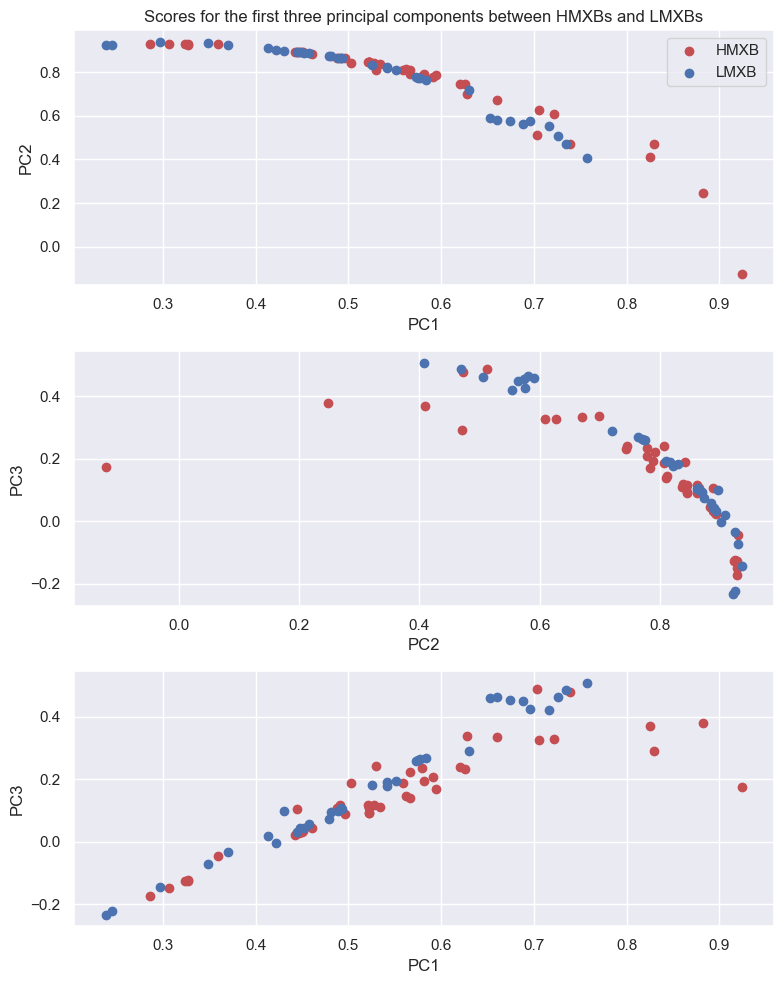

In [355]:
xray_binary_classification = {
    'swift_j1727': 'LMXB',
    'cen_x-3': 'HMXB',
    'gro_j1008-57': 'HMXB',
    'gx_5-1': 'LMXB',
    'gx_9+1': 'LMXB',
    'gx_3+1': 'LMXB',
    'v395_car': 'LMXB',
    'gx_9+9': 'LMXB',
    'cir_x-1': 'HMXB',
    'lmc_x-1': 'HMXB',
    '4u_1735-44': 'LMXB',
    'sco_x-1': 'LMXB',
    '4u_1820-303': 'LMXB',
    'cyg_x-3': 'HMXB',
    'smc_x-1': 'HMXB',
    'gx_340+0': 'LMXB',
    'cyg_x-2': 'LMXB',
    'exo_2030+375': 'HMXB',
    'gx_13+1': 'LMXB',
    '4u_1728-34': 'LMXB',
    'vela_x-1': 'HMXB',
    'ls_v+44_17': 'HMXB',
    'swift_j0234': 'HMXB',
    'gx_349+2': 'LMXB',
    'gx_301-2': 'HMXB',
    'mcg-5-23-16': 'HMXB',
    '4u_1630-47': 'HMXB',
    '4u_1538-52': 'HMXB',
    'swift_j151857': 'HMXB',
    '4u_1957+115': 'LMXB',
    'gx_339-4': 'LMXB',
    'lmc_x-3': 'LMXB',
    'x_persei': 'HMXB',
    '4u_1624-49': 'LMXB',
    'her_x-1': 'HMXB',
    'xte_j1701-462': 'LMXB',
    'ser_x-1': 'LMXB',
    'srga_j144459': 'HMXB',
    '4u_1626-67': 'LMXB',
    'cyg_x-1': 'HMXB',
    'gs_1826-238': 'LMXB'
}
hmscores = []
lmscores = []
for i in range(spectra_Istokes.shape[1]):
    test_data_point = spectra_Istokes.iloc[:, i]
    test_data_point /= np.linalg.norm(test_data_point)
    k = 3  # Number of principal components to project onto
    obsid = spectra_Istokes.columns[i]
    source = f'{obsid.split("/")[0]}'

    scores = project_onto_pcs(test_data_point, pcs, k)
    if xray_binary_classification[source] == 'HMXB':
        hmscores.append(scores)
    else:
        lmscores.append(scores)
    # if xray_binary_classification[source] == 'HMXB':
    #     ax.scatter(scores[1], scores[2], color='r')
    # else:
    #     ax.scatter(scores[1], scores[2], color='b')
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
ax[0].scatter([x[0] for x in hmscores], [x[1] for x in hmscores], color='r', label='HMXB')
ax[0].scatter([x[0] for x in lmscores], [x[1] for x in lmscores], color='b', label='LMXB')
ax[1].scatter([x[1] for x in hmscores], [x[2] for x in hmscores], color='r', label='HMXB')
ax[1].scatter([x[1] for x in lmscores], [x[2] for x in lmscores], color='b', label='LMXB')
ax[2].scatter([x[0] for x in hmscores], [x[2] for x in hmscores], color='r', label='HMXB')
ax[2].scatter([x[0] for x in lmscores], [x[2] for x in lmscores], color='b', label='LMXB')

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC2')
ax[1].set_ylabel('PC3')
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC3')
ax[0].set_title('Scores for the first three principal components between HMXBs and LMXBs')
ax[0].legend()
fig.tight_layout()